In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.funcs import *
from pathlib import Path
from collections import defaultdict

# survival analysis
from lifelines.statistics import logrank_test

sns.set(font_scale = 1.25,
        style="whitegrid",
        rc={"figure.dpi":300, 'savefig.dpi':300, 'figure.figsize':(8,6)})

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path.home() / "data/bioinfo_sm207"

In [4]:
response = pd.read_csv(
    Path.home() / "data/zuma7_signatures_log2/rchop_meta.csv",
    index_col=0)
response.head()

,Gene Expression Subgroup,Gender,Age,PFS event,PFS time,B.cells_group,Plasma.cells_group,T.cells.CD8_group,T.cells.CD4_group,T.cells.follicular.helper_group,...,g.Neutrophils.LD_group,g.NK_group,g.pDCs_group,g.Plasmablasts_group,g.T.CD4.Memory_group,g.T.CD4.Naive_group,g.T.CD8.Memory_group,g.T.CD8.Naive_group,g.T.gd.non.Vd2_group,g.T.gd.Vd2_group
DLBCL11537,GCB,M,58.0,0.0,3.991786,S02,unassigned,S02,S03,S03,...,low,low,low,low,low,low,low,high,low,low
DLBCL10477,ABC,F,53.0,1.0,0.290212,S04,unassigned,unassigned,unassigned,unassigned,...,low,low,low,low,low,low,low,low,low,low
DLBCL10471,ABC,M,83.0,1.0,6.488706,S05,unassigned,S02,S03,S03,...,low,low,low,low,low,low,low,high,low,low
DLBCL11186,ABC,M,71.0,0.0,10.086242,S04,S01,S03,S03,S01,...,low,low,low,low,low,low,low,low,low,low
DLBCL10542,ABC,M,30.0,1.0,0.536619,S04,unassigned,unassigned,unassigned,unassigned,...,low,low,low,low,high,low,low,low,low,low


In [5]:
arm = "Reddy"
response = response.loc[response["Actual Arm Code"]==arm]
# remove old results
response = response.iloc[:, :5]
response['Actual Arm Code'] = arm

In [6]:
# ecotyper results
ecotyper_results = [d for d in (data_path/f"ecotyper_outs/{arm.lower()}_tpm").iterdir() if d.is_dir()]
len(ecotyper_results)

14

In [7]:
ecotyper_results[:3]

[PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/reddy_tpm/B.cells'),
 PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/reddy_tpm/Plasma.cells'),
 PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/reddy_tpm/T.cells.CD8')]

In [8]:
# add assignment to response for each output
for d in ecotyper_results:
    if d.name == "Ecotypes":
        fn = "ecotype_assignment.txt"
        col = "Ecotype"
    else:
        fn = "state_assignment.txt"
        col = "State"
    assignment = pd.read_csv(d/fn, sep="\t")

    # use ID as index
    assignment.set_index("ID", inplace=True)
    # remove index name
    assignment.index.name = None
    # assignment.index = assignment.index.map(lambda x: x.replace("_", "-"))
    # add the col to the response
    res = assignment[col]
    res.name = f"ecotyper_{d.name}_group"
    response = response.join(res)
    # fill na with unassigned 
    response[f"ecotyper_{d.name}_group"].fillna("Unassigned", inplace=True)

In [9]:
# granulator results with nnls_s0
nnls_s0 = pd.read_csv(data_path/f"granulator_outs/{arm.lower()}/nnls_ABIS_S0.csv", index_col=0)
nnls_s0.head()

,B.Memory,B.Naive,Basophils.LD,MAIT,mDCs,Monocytes.C,Monocytes.NC.I,Neutrophils.LD,NK,pDCs,Plasmablasts,T.CD4.Memory,T.CD4.Naive,T.CD8.Memory,T.CD8.Naive,T.gd.non.Vd2,T.gd.Vd2
Reddy_2044,15.84,3.62,0.00,0.45,0.90,0.45,1.36,1.36,0.45,0.00,3.17,6.79,1.81,0.0,0.45,0.0,0
Reddy_2072,5.88,3.62,0.45,0.00,1.81,0.00,0.90,0.90,0.00,0.90,2.26,36.20,0.00,0.0,0.00,0.0,0
Reddy_2075,13.57,5.88,0.00,1.36,1.36,0.00,0.90,4.52,0.45,0.00,2.71,13.12,0.00,0.0,0.45,0.0,0
Reddy_2078,0.45,0.00,0.90,0.00,1.36,4.07,4.07,1.81,2.26,2.71,0.45,13.12,3.17,0.0,0.00,0.0,0
Reddy_2079,25.34,0.00,0.00,1.36,0.45,2.26,1.36,4.52,0.00,0.00,0.00,13.12,0.00,0.0,0.00,0.0,0


<Axes: ylabel='Frequency'>

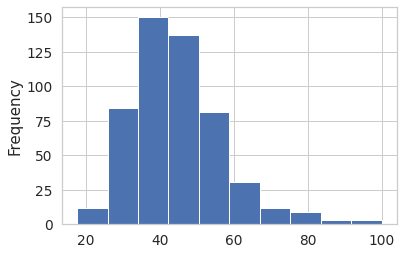

In [10]:
nnls_s0.sum(axis=1).plot.hist()

In [11]:
# inplace "_" with "-" in the index
# nnls_s0.index = nnls_s0.index.map(lambda x: x.replace("_", "-"))

# add granulator_ to the columns
nnls_s0.columns = nnls_s0.columns.map(lambda x: "granulator_" + x)

# add the assignment to the response
response = response.join(nnls_s0)
response.head()

,Gene Expression Subgroup,Gender,Age,PFS event,PFS time,Actual Arm Code,ecotyper_B.cells_group,ecotyper_Plasma.cells_group,ecotyper_T.cells.CD8_group,ecotyper_T.cells.CD4_group,...,granulator_Neutrophils.LD,granulator_NK,granulator_pDCs,granulator_Plasmablasts,granulator_T.CD4.Memory,granulator_T.CD4.Naive,granulator_T.CD8.Memory,granulator_T.CD8.Naive,granulator_T.gd.non.Vd2,granulator_T.gd.Vd2
Reddy_3936,GCB,F,59.9,0.0,8.58,Reddy,S02,Unassigned,S03,S03,...,1.81,0.00,0.90,0.00,11.31,4.52,0.0,0.00,0.0,0
Reddy_3616,ABC,M,65.4,0.0,5.62,Reddy,S05,Unassigned,S04,Unassigned,...,2.71,0.00,1.36,1.36,6.79,2.71,0.0,1.81,0.0,0
Reddy_2249,ABC,F,45.8,0.0,11.14,Reddy,S03,S01,S01,Unassigned,...,1.36,0.00,0.90,1.81,12.67,0.90,0.0,0.45,0.0,0
Reddy_3628,GCB,M,56.6,0.0,5.17,Reddy,S04,S02,S04,S02,...,1.81,0.00,1.36,0.45,13.12,0.00,0.0,0.00,0.0,0
Reddy_3910,ABC,M,69.4,1.0,1.19,Reddy,S02,S03,S03,S04,...,3.17,1.36,1.36,0.90,0.45,11.76,0.0,0.00,0.0,0


In [12]:
# save response
response.to_csv(data_path/f"step03_{arm.lower()}_response.csv")
response.to_parquet(data_path/f"step03_{arm.lower()}_response.parquet")